In [1]:
import math
import pandas as pd
import tqdm
import numpy as np

import torch
import torch.utils.data as data
import torch.optim as optim

from MINE import controller, datasets, losses, models

In [15]:
def experiment(is_imine):
    data_loader = data.DataLoader(
        datasets.IntegerPairDataset(
            number_of_cases=16,
            x_encoding='one_hot',
            y_encoding='one_hot',
            transform=datasets.TransformToTensor()
        ),
        batch_size=1,
    )
    if is_imine:
        loss = losses.imine_loss(target_value=0, regularizer_weight=0.01)
    else:
        loss = losses.mine_loss()

    network = models.ConcatNet(16, 64)
    optimizer = optim.SGD(network.parameters(), lr=0.1)

    agent = controller.MINEController(
        data_loader=data_loader, loss=loss, network=network, optimizer=optimizer
    )
    
    agent.to(0)
    agent.train()
    for i in tqdm.tqdm(range(5000)):
        agent.step()

    return agent

In [29]:
df = [experiment(True).history, experiment(False).history]

100%|██████████| 5000/5000 [00:17<00:00, 283.86it/s]


<IPython.core.display.Javascript object>


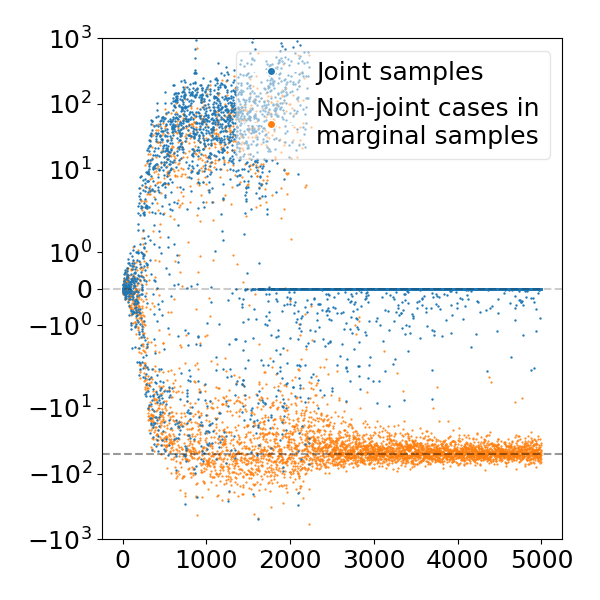

<IPython.core.display.Javascript object>


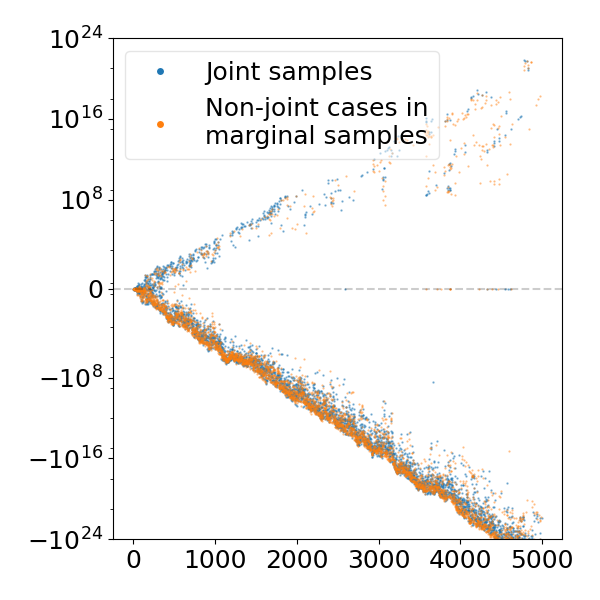

In [157]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib

matplotlib.rc('font', size=18)


for i in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    df_j = df[i].joint_value.to_numpy()
    df_m = df[i].marginal_value.to_numpy()[~df[i].is_joint_case.to_numpy().astype(bool)]
    if i == 0:
        ax.scatter(
            np.where(~df[i].is_joint_case.to_numpy().astype(bool))[0],
            df_m,
            s=0.3, alpha=1,
            c='C1'
        )
        ax.scatter(
            list(range(len(df_j))),
            list(df_j),
            s=0.5, alpha=1,
            c='C0'
        )
    else:
        ax.scatter(
            list(range(len(df_j))),
            list(df_j),
            s=0.5, alpha=0.5,
            c='C0'
        )
        ax.scatter(
            np.where(~df[i].is_joint_case.to_numpy().astype(bool))[0],
            list(df_m),
            s=0.3, alpha=0.5,
            c='C1'
        )
        
    ax.set_yscale('symlog')
    ax.legend([Line2D([0], [0], color='w', marker='o', markerfacecolor='C0', alpha=1),
                    Line2D([0], [0], color='w', marker='o', markerfacecolor='C1', alpha=1),],
                   ['Joint samples', 'Non-joint cases in\nmarginal samples'],
                  loc='upper right' if i == 0 else 'upper left', framealpha=0.5)
    if i == 0:
        ax.axhline(0, color='black', alpha=0.2, ls='--')
        ax.axhline(-50, color='black', alpha=0.4, ls='--')
        ax.set_yticks([-1000, -100, -10, -1, 0, 1, 10, 100, 1000])
        ax.set_ylim(-1000, 1000)
    else:
        ax.axhline(0, color='black', alpha=0.2, ls='--')
        ax.set_yticks([-1.e+24, -1.e+16, -1.e+8, 0.e+0, 1.e+08, 1.e+16, 1.e+24])
        ax.set_ylim(-1.e+24, 1.e+24)

    ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000])
    
    plt.tight_layout()
    plt.show()

In [146]:
df[0].marginal_value.to_numpy()[~df[0].is_joint_case.to_numpy().astype(bool)].index

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [154]:
np.where(~df[0].is_joint_case.to_numpy().astype(bool))[0].shape

(4722,)